#About Notebook

This notebook implement vanilla RNN model as a baseline for the stock price movement prediction.

In [11]:
import pandas as pd
import numpy as np
import os
import datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
!wget $url/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget $url/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
import talib

(Reading database ... 144891 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
/sbin/ldconfig.real: /usr/local/lib/python3.6/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link



## Data

In [4]:
df = pd.read_csv('/content/drive/MyDrive/ADL_Final/AAPL_tick_minute.csv', index_col = [0])
df.tail()

NameError: ignored

In [13]:
df_bid = pd.read_csv('/content/drive/MyDrive/ADL_Final/AAPL.USUSD_Candlestick_1_M_BID.csv')
df_ask = pd.read_csv('/content/drive/MyDrive/ADL_Final/AAPL.USUSD_Candlestick_1_M_ASK.csv')
#x = Bid, y = 
df = df_bid.merge(df_ask, on = 'Local time', how = 'inner')
df.head()

,Local time,Open_x,High_x,Low_x,Close_x,Volume_x,Open_y,High_y,Low_y,Close_y,Volume_y
0,02.01.2020 09:30:00.000 GMT-0500,296.248,296.268,295.367,295.678,0.7800,296.302,296.303,295.443,295.742,0.6639
1,02.01.2020 09:31:00.000 GMT-0500,295.768,295.818,295.657,295.748,0.0825,295.862,295.882,295.753,295.842,0.0808
2,02.01.2020 09:32:00.000 GMT-0500,295.748,295.778,295.678,295.758,0.0975,295.842,295.842,295.752,295.842,0.0806
3,02.01.2020 09:33:00.000 GMT-0500,295.758,295.838,295.637,295.838,0.4275,295.812,295.882,295.702,295.882,0.4231
4,02.01.2020 09:34:00.000 GMT-0500,295.838,296.897,295.838,296.868,1.8375,295.883,296.953,295.883,296.942,1.5123


In [14]:
df['Open'] = (df['Open_x'] + df['Open_y'])/2
df['Close'] = (df['Close_x'] + df['Close_y'])/2
df['High'] = (df['High_x'] + df['High_y'])/2
df['Low'] = (df['Low_x'] + df['Low_y'])/2

df = df.loc[:, ['Local time', 'Open', 'Close', 'High', 'Low', 'Volume_x', 'Volume_y']]
df

,Local time,Open,Close,High,Low,Volume_x,Volume_y
0,02.01.2020 09:30:00.000 GMT-0500,296.2750,295.710,296.2855,295.4050,0.7800,0.6639
1,02.01.2020 09:31:00.000 GMT-0500,295.8150,295.795,295.8500,295.7050,0.0825,0.0808
2,02.01.2020 09:32:00.000 GMT-0500,295.7950,295.800,295.8100,295.7150,0.0975,0.0806
3,02.01.2020 09:33:00.000 GMT-0500,295.7850,295.860,295.8600,295.6695,0.4275,0.4231
4,02.01.2020 09:34:00.000 GMT-0500,295.8605,296.905,296.9250,295.8605,1.8375,1.5123
...,...,...,...,...,...,...,...
93178,11.12.2020 15:55:00.000 GMT-0500,122.2200,122.185,122.2550,122.1650,3.3619,3.4400
93179,11.12.2020 15:56:00.000 GMT-0500,122.1950,122.210,122.2205,122.1350,1.7607,1.6700
93180,11.12.2020 15:57:00.000 GMT-0500,122.2200,122.235,122.2455,122.1395,3.7251,3.8800
93181,11.12.2020 15:58:00.000 GMT-0500,122.2450,122.230,122.2555,122.1495,4.1460,4.3800


In [15]:
#df['HLAvg'] = df['Close_bid'].add(df['Close_ask']).div(2)
df['MA'] = df['Close'].rolling(window=14).mean()
df = df.dropna()
df.index = np.arange(0, len(df))
df['Returns'] = np.log(df['MA']/df['MA'].shift(1))
df = df.dropna()
df.index = np.arange(0, len(df))
df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Local time,Open,Close,High,Low,Volume_x,Volume_y,MA,Returns
0,02.01.2020 09:44:00.000 GMT-0500,297.3300,297.325,297.3300,297.3250,0.0225,0.0400,297.035000,0.000388
1,02.01.2020 09:45:00.000 GMT-0500,297.2400,297.165,297.2400,297.1600,0.1050,0.0412,297.132857,0.000329
2,02.01.2020 10:02:00.000 GMT-0500,297.9000,297.660,297.9250,297.5145,3.0150,2.6786,297.265714,0.000447
3,02.01.2020 10:03:00.000 GMT-0500,297.6695,297.785,297.8155,297.5945,3.1800,2.8610,297.403214,0.000462
4,02.01.2020 10:04:00.000 GMT-0500,297.7850,297.815,297.9255,297.6850,3.0375,2.3263,297.468214,0.000219
...,...,...,...,...,...,...,...,...,...
93164,11.12.2020 15:55:00.000 GMT-0500,122.2200,122.185,122.2550,122.1650,3.3619,3.4400,122.062857,-0.000053
93165,11.12.2020 15:56:00.000 GMT-0500,122.1950,122.210,122.2205,122.1350,1.7607,1.6700,122.056429,-0.000053
93166,11.12.2020 15:57:00.000 GMT-0500,122.2200,122.235,122.2455,122.1395,3.7251,3.8800,122.063214,0.000056
93167,11.12.2020 15:58:00.000 GMT-0500,122.2450,122.230,122.2555,122.1495,4.1460,4.3800,122.071786,0.000070


In [16]:
from talib import MA_Type

timeperiod = 14

upper, middle, lower = talib.BBANDS(df['Close'], matype=MA_Type.T3)

df['BBand_upper'] = upper
df['BBand_middle'] = middle
df['BBand_lower'] = lower

adx = talib.ADX(df['High'], df['Low'], df['Close'], timeperiod= timeperiod)
dx = talib.DX(df['High'], df['Low'], df['Close'], timeperiod= timeperiod)

macd, macdsignal, macdhist = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
slowk, slowd = talib.STOCH(df['High'], df['Low'], df['Close'], fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)


df['Average Directional Index'] = adx
df['Directional Index'] = dx
df['MACD'] = macd
df['MACD_signal'] = macdsignal
df['MACD hist'] = macdhist
df['stochastic k'] = slowk
df['stochastic d'] = slowd

In [17]:
#Movement
df['movement'] = 100

#Threshold 10%
for i in range(1,len(df)):
  if df.loc[i, 'Returns'] > 0:
    df.loc[i,'movement'] = 1
  elif df.loc[i, 'Returns'] < 0:
    df.loc[i,'movement'] = 0

In [18]:
df = df.dropna()
df = df[df.movement != 100]

df.index = np.arange(0, len(df))
df

,Local time,Open,Close,High,Low,Volume_x,Volume_y,MA,Returns,BBand_upper,BBand_middle,BBand_lower,Average Directional Index,Directional Index,MACD,MACD_signal,MACD hist,stochastic k,stochastic d,movement
0,02.01.2020 11:10:00.000 GMT-0500,298.280,298.275,298.2855,298.1595,1.6425,1.3710,298.101786,0.000179,298.301724,298.168908,298.036092,21.999526,28.152144,0.097913,0.026004,0.071909,96.211233,93.470569,1
1,02.01.2020 11:11:00.000 GMT-0500,298.270,298.365,298.4000,298.2695,1.9425,1.5707,298.126071,0.000081,298.382964,298.225534,298.068105,22.803601,33.256577,0.116295,0.044062,0.072233,94.438553,94.659463,1
2,02.01.2020 11:12:00.000 GMT-0500,298.370,298.560,298.5755,298.3695,2.1375,1.7171,298.163929,0.000127,298.541696,298.301913,298.062130,24.050637,40.262092,0.144927,0.064235,0.080692,94.492828,95.047538,1
3,02.01.2020 11:13:00.000 GMT-0500,298.555,298.490,298.6050,298.4095,2.3550,1.9389,298.187500,0.000079,298.605967,298.376306,298.146645,25.288160,41.375968,0.160124,0.083413,0.076711,86.986386,91.972589,1
4,02.01.2020 11:14:00.000 GMT-0500,298.480,298.730,298.7355,298.4795,1.6500,1.3316,298.218929,0.000105,298.780408,298.465232,298.150056,26.778913,46.158695,0.189351,0.104601,0.084750,90.044848,90.508021,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92818,11.12.2020 15:55:00.000 GMT-0500,122.220,122.185,122.2550,122.1650,3.3619,3.4400,122.062857,-0.000053,122.279334,122.036715,121.794096,18.047640,19.461349,-0.019483,-0.026656,0.007173,56.997702,37.459158,0
92819,11.12.2020 15:56:00.000 GMT-0500,122.195,122.210,122.2205,122.1350,1.7607,1.6700,122.056429,-0.000053,122.342990,122.082559,121.822129,17.821065,14.875593,-0.007855,-0.022896,0.015041,83.065749,58.266148,0
92820,11.12.2020 15:57:00.000 GMT-0500,122.220,122.235,122.2455,122.1395,3.7251,3.8800,122.063214,0.000056,122.371346,122.129983,121.888620,17.813164,17.710453,0.003339,-0.017649,0.020988,83.830275,74.631242,1
92821,11.12.2020 15:58:00.000 GMT-0500,122.245,122.230,122.2555,122.1495,4.1460,4.3800,122.071786,0.000070,122.207497,122.171386,122.135275,17.888957,18.874260,0.011672,-0.011785,0.023457,87.270642,84.722222,1


In [19]:
train_size = int(len(df) * .7)
df_train =  df.iloc[:train_size]
df_val = df.iloc[train_size:]

print(len(df_train), len(df_val))

64976 27847


In [20]:
df_val

,Local time,Open,Close,High,Low,Volume_x,Volume_y,MA,Returns,BBand_upper,BBand_middle,BBand_lower,Average Directional Index,Directional Index,MACD,MACD_signal,MACD hist,stochastic k,stochastic d,movement
64976,31.08.2020 13:22:00.000 GMT-0400,130.725,130.580,130.7505,130.5750,4.7450,4.3700,130.407500,0.000389,130.785107,130.593754,130.402401,43.595720,59.361556,0.283872,0.265196,0.018676,81.604078,86.432993,1
64977,31.08.2020 13:23:00.000 GMT-0400,130.585,130.730,130.7555,130.5595,4.1700,3.9575,130.436786,0.000225,130.805117,130.634636,130.464154,44.531053,56.690375,0.287873,0.269732,0.018142,82.072863,85.080923,1
64978,31.08.2020 13:24:00.000 GMT-0400,130.730,130.830,130.8405,130.7145,4.4725,4.3600,130.478571,0.000320,130.874116,130.685394,130.496672,45.678223,60.591431,0.295705,0.274926,0.020778,82.248863,81.975268,1
64979,31.08.2020 13:25:00.000 GMT-0400,130.830,130.730,130.8905,130.7095,4.7875,4.6250,130.515714,0.000285,130.885945,130.726145,130.566345,46.895400,62.718710,0.290493,0.278040,0.012453,80.258622,81.526783,1
64980,31.08.2020 13:26:00.000 GMT-0400,130.735,130.435,130.7505,130.4195,5.9950,5.7825,130.536071,0.000156,130.994608,130.717885,130.441161,45.094947,21.689047,0.259567,0.274345,-0.014778,50.629608,71.045698,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92818,11.12.2020 15:55:00.000 GMT-0500,122.220,122.185,122.2550,122.1650,3.3619,3.4400,122.062857,-0.000053,122.279334,122.036715,121.794096,18.047640,19.461349,-0.019483,-0.026656,0.007173,56.997702,37.459158,0
92819,11.12.2020 15:56:00.000 GMT-0500,122.195,122.210,122.2205,122.1350,1.7607,1.6700,122.056429,-0.000053,122.342990,122.082559,121.822129,17.821065,14.875593,-0.007855,-0.022896,0.015041,83.065749,58.266148,0
92820,11.12.2020 15:57:00.000 GMT-0500,122.220,122.235,122.2455,122.1395,3.7251,3.8800,122.063214,0.000056,122.371346,122.129983,121.888620,17.813164,17.710453,0.003339,-0.017649,0.020988,83.830275,74.631242,1
92821,11.12.2020 15:58:00.000 GMT-0500,122.245,122.230,122.2555,122.1495,4.1460,4.3800,122.071786,0.000070,122.207497,122.171386,122.135275,17.888957,18.874260,0.011672,-0.011785,0.023457,87.270642,84.722222,1


In [21]:
feature_columns = ['Open', 'High', 'Low', 'Volume_x', 'Volume_y', 'MA', 'Returns',
       'BBand_upper', 'BBand_middle', 'BBand_lower', 'Directional Index',
       'Average Directional Index', 'MACD', 'MACD_signal', 'MACD hist',
        'stochastic k', 'stochastic d']

In [22]:
#Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

feature_columns = ['Open', 'High', 'Low', 'Volume_x', 'Volume_y', 'MA', 'Returns',
       'BBand_upper', 'BBand_middle', 'BBand_lower', 'Directional Index',
       'Average Directional Index', 'MACD', 'MACD_signal', 'MACD hist',
        'stochastic k', 'stochastic d']


for feature in feature_columns:
  df_train[feature] = scaler.fit_transform(df_train[[feature]].values)
  df_val[feature] = scaler.transform(df_val[[feature]])



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [23]:
df_val.tail()

,Local time,Open,Close,High,Low,Volume_x,Volume_y,MA,Returns,BBand_upper,BBand_middle,BBand_lower,Average Directional Index,Directional Index,MACD,MACD_signal,MACD hist,stochastic k,stochastic d,movement
92818,11.12.2020 15:55:00.000 GMT-0500,-0.010889,122.185,-0.011785,-0.010825,0.292769,0.304425,-0.013394,0.971103,0.044383,0.070090,0.326082,0.138746,0.196830,0.943951,0.943662,0.769829,0.570910,0.378162,0
92819,11.12.2020 15:56:00.000 GMT-0500,-0.010954,122.210,-0.011874,-0.010902,0.153018,0.147788,-0.013410,0.971103,0.044479,0.070199,0.326130,0.136073,0.150448,0.944056,0.943701,0.769962,0.832032,0.589005,0
92820,11.12.2020 15:57:00.000 GMT-0500,-0.010889,122.235,-0.011810,-0.010890,0.324469,0.343363,-0.013393,0.971658,0.044522,0.070311,0.326245,0.135980,0.179121,0.944158,0.943755,0.770062,0.839690,0.754837,1
92821,11.12.2020 15:58:00.000 GMT-0500,-0.010825,122.230,-0.011784,-0.010865,0.361204,0.387611,-0.013370,0.971733,0.044274,0.070409,0.326669,0.136874,0.190892,0.944233,0.943815,0.770104,0.874152,0.857092,1
92822,11.12.2020 15:59:00.000 GMT-0500,-0.010851,122.455,-0.011219,-0.010683,0.712477,0.765929,-0.013285,0.972752,0.044603,0.070547,0.326496,0.154827,0.396480,0.944453,0.943914,0.770354,0.908502,0.882878,1


In [24]:
from tensorflow.keras.utils import to_categorical

Y_train = df_train['movement']
Y_val = df_val['movement']

print(len(Y_train[Y_train == 1]), len(Y_train[Y_train == 0]))
print(len(Y_val[Y_val == 1]), len(Y_val[Y_val == 0]))

Y_train = to_categorical(Y_train, 2)
Y_val = to_categorical(Y_val, 2)

34142 30834
14208 13639


In [25]:
def convert_raw_samples_to_model_samples(scd_log_rtns, movements, window_size):
    X, y = [], []
    len_log_rtns = len(scd_log_rtns)
    for i in range(window_size, len_log_rtns):
        X.append(scd_log_rtns[i-window_size:i])
        y.append(movements[i])
    X, y = np.asarray(X), np.asarray(y)
    #X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y

def reshape_by_level(input_array, level):
  out_array = input_array.reshape(-1,1)[::level]
  orig_input_len = len(input_array)
  mod = len(out_array) % orig_input_len
  out_array = out_array[:len(out_array)-mod].reshape((orig_input_len,-1))

  return out_array

In [26]:
df_train = df_train.dropna()
df_train.index = np.arange(0,len(df_train))
df_val.index = np.arange(0,len(df_val))

df_train = df_train[feature_columns]
df_val  = df_val[feature_columns]

In [27]:
window_size = 256
X_train, y_train = convert_raw_samples_to_model_samples(df_train, Y_train, window_size)
X_val, y_val = convert_raw_samples_to_model_samples(df_val, Y_val, window_size)
#X_test, y_test = convert_raw_samples_to_model_samples(test_values, test_y_values, window_size)

## Embedding

Reference: [paper](https://arxiv.org/pdf/1907.05321.pdf), [code](https://github.com/JanSchm/CapMarket)

In [28]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config

In [29]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [30]:

# -*- coding: utf-8 -*-
"""Confusion matrix.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1dbeSXmnx5b6mUMXXYMlYVw-V20-fDdPc
"""

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## Model

##LSTM 

In [31]:

# compile the model
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

# fit the model
#history = model.fit(Xtrain, ytrain, validation_split=0.3, epochs=10, verbose=0)


def create_LSTM(X, classification, embedding):
  if len(X.shape) == 2:
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
  input_seq = Input(shape = (X.shape[1], X.shape[2]))

  if embedding:
    time_embedding = Time2Vector(X.shape[1])
    x = time_embedding(input_seq)
    x = Concatenate(axis=-1)([input_seq, x])
    x = LSTM(64, return_sequences= False)(x)
  else:
    x = LSTM(64, return_sequences= False)(input_seq)
  
  if classification:
    x = Dropout(0.1)(x)
    x = Dense(128, activation = 'relu')(x)
    #out = Dense(1, activation = 'softmax')(x)
    out = Dense(2, activation="softmax", name="output")(x)
    model = Model(inputs = input_seq, outputs = out)
    model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(1e-5), metrics = ['acc',f1_m,precision_m, recall_m])
  else:
    x = Dropout(0.1)(x)
    out = Dense(1)(x)
    model = Model(inputs = input_seq, outputs = out)
    model.compile(loss = 'mse', optimizer = tf.keras.optimizers.Adam(1e-5), metrics = ['mae', 'mape'])
  
  return model

In [46]:
#With Time Embedding
model_w_timeembedding = create_LSTM(X_train, True, True)

In [47]:
model_w_timeembedding.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 17)]    0                                            
__________________________________________________________________________________________________
time2_vector_2 (Time2Vector)    (None, 256, 2)       1024        input_3[0][0]                    
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 256, 19)      0           input_3[0][0]                    
                                                                 time2_vector_2[0][0]             
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 64)           21504       concatenate_2[0][0]        

In [48]:
from sklearn.utils import compute_class_weight
##classWeight = compute_class_weight('balanced', outputLabels, outputs) 
#classWeight = dict(enumerate(classWeight))
#model.fit(X_train, y_train, batch_size = batch_size, nb_epoch = nb_epochs, show_accuracy = True, verbose = 2, validation_data = (X_test, y_test), class_weight=classWeight)
history = model_w_timeembedding.fit(X_train, y_train,epochs=5,  validation_data=(X_val, y_val))

Epoch 1/5
2023/2023 [==============================] - 32s 15ms/step - loss: 0.6661 - acc: 0.6315 - f1_m: 0.6315 - precision_m: 0.6315 - recall_m: 0.6315 - val_loss: 0.5705 - val_acc: 0.7400 - val_f1_m: 0.7401 - val_precision_m: 0.7401 - val_recall_m: 0.7401
Epoch 2/5
2023/2023 [==============================] - 29s 14ms/step - loss: 0.4931 - acc: 0.7921 - f1_m: 0.7921 - precision_m: 0.7921 - recall_m: 0.7921 - val_loss: 0.4667 - val_acc: 0.7834 - val_f1_m: 0.7835 - val_precision_m: 0.7835 - val_recall_m: 0.7835
Epoch 3/5
2023/2023 [==============================] - 29s 14ms/step - loss: 0.4166 - acc: 0.8115 - f1_m: 0.8115 - precision_m: 0.8115 - recall_m: 0.8115 - val_loss: 0.4502 - val_acc: 0.7843 - val_f1_m: 0.7843 - val_precision_m: 0.7843 - val_recall_m: 0.7843
Epoch 4/5
2023/2023 [==============================] - 30s 15ms/step - loss: 0.4057 - acc: 0.8109 - f1_m: 0.8109 - precision_m: 0.8109 - recall_m: 0.8109 - val_loss: 0.4407 - val_acc: 0.7887 - val_f1_m: 0.7887 - val_precisi

In [49]:
y_pred = model_w_timeembedding.predict(X_val)
y_pred = [y_pred[i].argmax() for i in range(len(y_pred))]
print(set(y_pred))

num =[0,0]
for i in range(len(y_pred)):
  num[y_pred[i]] += 1 

print(num)

y_true =  [y_val[i].argmax() for i in range(len(y_val))]
num =[0,0]
for i in range(len(y_true)):
  num[y_true[i]] += 1 
print(num)

{0, 1}
[9392, 18199]
[13524, 14067]


In [50]:
len(y_pred)

27591

In [62]:
df_export = pd.DataFrame(y_pred)
df_export.columns = ['with time emebdding']
df_export

,with time emebdding
0,1
1,1
2,1
3,1
4,1
...,...
27586,0
27587,0
27588,0
27589,1


In [64]:
df_export['without time embedding'] = y_pred_wo_timeembedding
df_export.to_csv('/content/drive/MyDrive/ADL_Final/LSTM_prediction.csv')

In [55]:

from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.62      0.74     13524
           1       0.72      0.93      0.81     14067

    accuracy                           0.78     27591
   macro avg       0.81      0.78      0.77     27591
weighted avg       0.81      0.78      0.77     27591



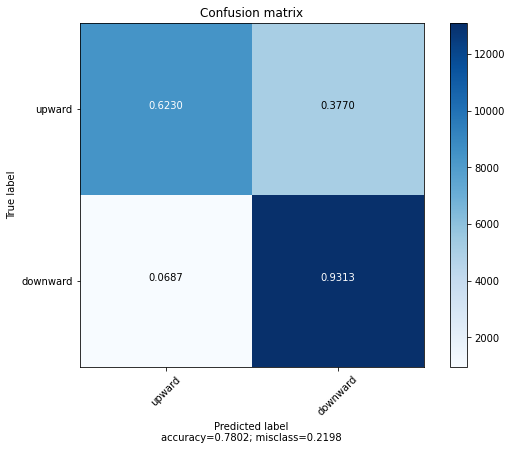

In [56]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm,
                      ['upward','downward'],
                      title='Confusion matrix',
                      cmap=None,
                      normalize=True)

In [57]:
#Without Time Embedding
model_wo_timeembedding = create_LSTM(X_train, True, False)
model_wo_timeembedding.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 17)]         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                20992     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
output (Dense)               (None, 2)                 258       
Total params: 29,570
Trainable params: 29,570
Non-trainable params: 0
_________________________________________________________________


In [58]:
history = model_wo_timeembedding.fit(X_train, y_train,epochs=5,  validation_data=(X_val, y_val))

Epoch 1/5
2023/2023 [==============================] - 34s 16ms/step - loss: 0.6577 - acc: 0.6268 - f1_m: 0.6268 - precision_m: 0.6268 - recall_m: 0.6268 - val_loss: 0.5668 - val_acc: 0.7131 - val_f1_m: 0.7129 - val_precision_m: 0.7129 - val_recall_m: 0.7129
Epoch 2/5
2023/2023 [==============================] - 32s 16ms/step - loss: 0.4863 - acc: 0.7935 - f1_m: 0.7935 - precision_m: 0.7935 - recall_m: 0.7935 - val_loss: 0.4883 - val_acc: 0.7584 - val_f1_m: 0.7585 - val_precision_m: 0.7585 - val_recall_m: 0.7585
Epoch 3/5
2023/2023 [==============================] - 32s 16ms/step - loss: 0.4208 - acc: 0.8086 - f1_m: 0.8086 - precision_m: 0.8086 - recall_m: 0.8086 - val_loss: 0.4658 - val_acc: 0.7698 - val_f1_m: 0.7699 - val_precision_m: 0.7699 - val_recall_m: 0.7699
Epoch 4/5
2023/2023 [==============================] - 33s 16ms/step - loss: 0.4052 - acc: 0.8141 - f1_m: 0.8141 - precision_m: 0.8141 - recall_m: 0.8141 - val_loss: 0.4418 - val_acc: 0.7867 - val_f1_m: 0.7868 - val_precisi

In [59]:
y_pred_wo_timeembedding = model_wo_timeembedding.predict(X_val)
y_pred_wo_timeembedding = [y_pred_wo_timeembedding[i].argmax() for i in range(len(y_pred_wo_timeembedding))]
print(set(y_pred))

num =[0,0]
for i in range(len(y_pred_wo_timeembedding)):
  num[y_pred_wo_timeembedding[i]] += 1 

print(num)

y_true =  [y_val[i].argmax() for i in range(len(y_val))]
num =[0,0]
for i in range(len(y_true)):
  num[y_true[i]] += 1 
print(num)

print(classification_report(y_true, y_pred))

{0, 1}
[9883, 17708]
[13524, 14067]
              precision    recall  f1-score   support

           0       0.90      0.62      0.74     13524
           1       0.72      0.93      0.81     14067

    accuracy                           0.78     27591
   macro avg       0.81      0.78      0.77     27591
weighted avg       0.81      0.78      0.77     27591



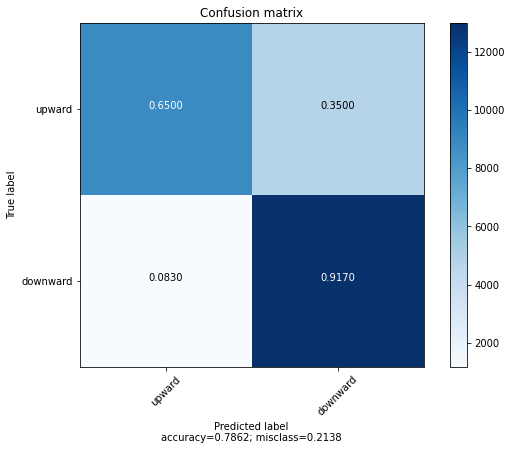

In [68]:
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm,
                      ['upward','downward'],
                      title='Confusion matrix',
                      cmap=None,
                      normalize=True)

## LSTM with Attention

In [65]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
 
    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
 
        return context_vector, attention_weights

In [66]:
#Attention

def create_LSTM_attention(X, classification, embedding):
  input_seq = Input(shape = (X.shape[1], X.shape[2]))
  attn_layer = Attention(10)

  if embedding:
    time_embedding = Time2Vector(X.shape[1])
    x = time_embedding(input_seq)
    x = Concatenate(axis=-1)([input_seq, x])
    lstm, state_c, state_h = LSTM(64, return_sequences= True, return_state = True)(x)

  else:
    lstm, state_c, state_h = LSTM(64, return_sequences= True, return_state = True)(input_seq)

  if classification:
    x, attention_weights = attn_layer(lstm, state_h)
    x = Dense(128, activation = 'relu')(x)
    #out = Dense(1, activation = 'softmax')(x)
    out = Dense(2, activation="softmax", name="output")(x)
    model = Model(inputs = input_seq, outputs = out)
    model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(1e-4), metrics = ['acc',f1_m,precision_m, recall_m])

  else:
    vector, attention_weights = attn_layer(lstm, state_h)
    dense1 = Dense(20, activation="relu")(vector)
    dropout = Dropout(0.1)(dense1)
    out = Dense(1)(dropout)
    model = Model(inputs = input_seq, outputs = out)
    model.compile(loss = 'mse', optimizer = 'Adam', metrics = ['mae', 'mape'])
  return model

In [67]:
#With Time Embedding
model_att_wembedding = create_LSTM_attention(X_train, True, True)

In [68]:
model_att_wembedding.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 17)]    0                                            
__________________________________________________________________________________________________
time2_vector_3 (Time2Vector)    (None, 256, 2)       1024        input_5[0][0]                    
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 256, 19)      0           input_5[0][0]                    
                                                                 time2_vector_3[0][0]             
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 256, 64), (N 21504       concatenate_3[0][0]        

In [69]:
history = model_att_wembedding.fit(X_train, y_train,epochs=5,  validation_data=(X_val, y_val))

Epoch 1/5
2023/2023 [==============================] - 38s 18ms/step - loss: 0.6685 - acc: 0.5565 - f1_m: 0.5565 - precision_m: 0.5565 - recall_m: 0.5565 - val_loss: 0.4894 - val_acc: 0.7611 - val_f1_m: 0.7612 - val_precision_m: 0.7612 - val_recall_m: 0.7612
Epoch 2/5
2023/2023 [==============================] - 37s 18ms/step - loss: 0.4156 - acc: 0.8100 - f1_m: 0.8100 - precision_m: 0.8100 - recall_m: 0.8100 - val_loss: 0.4621 - val_acc: 0.7747 - val_f1_m: 0.7748 - val_precision_m: 0.7748 - val_recall_m: 0.7748
Epoch 3/5
2023/2023 [==============================] - 35s 17ms/step - loss: 0.4022 - acc: 0.8134 - f1_m: 0.8134 - precision_m: 0.8134 - recall_m: 0.8134 - val_loss: 0.4357 - val_acc: 0.7911 - val_f1_m: 0.7911 - val_precision_m: 0.7911 - val_recall_m: 0.7911
Epoch 4/5
2023/2023 [==============================] - 36s 18ms/step - loss: 0.3972 - acc: 0.8159 - f1_m: 0.8159 - precision_m: 0.8159 - recall_m: 0.8159 - val_loss: 0.4343 - val_acc: 0.7922 - val_f1_m: 0.7922 - val_precisi

In [71]:
y_pred_att_wembedding = model_att_wembedding.predict(X_val)
y_pred_att_wembedding = [y_pred_att_wembedding[i].argmax() for i in range(len(y_pred_att_wembedding))]
print(set(y_pred_att_wembedding))

num =[0,0]
for i in range(len(y_pred_att_wembedding)):
  num[y_pred_att_wembedding[i]] += 1 

print(num)

y_true =  [y_val[i].argmax() for i in range(len(y_val))]
num =[0,0]
for i in range(len(y_true)):
  num[y_true[i]] += 1 
print(num)

print(classification_report(y_true, y_pred_att_wembedding))

{0, 1}
[8881, 18710]
[13524, 14067]
              precision    recall  f1-score   support

           0       0.91      0.60      0.72     13524
           1       0.71      0.95      0.81     14067

    accuracy                           0.78     27591
   macro avg       0.81      0.77      0.77     27591
weighted avg       0.81      0.78      0.77     27591



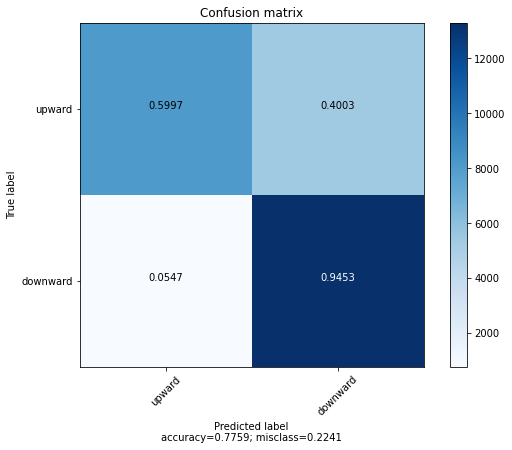

In [72]:
cm = confusion_matrix(y_true, y_pred_att_wembedding)
plot_confusion_matrix(cm,
                      ['upward','downward'],
                      title='Confusion matrix',
                      cmap=None,
                      normalize=True)

In [73]:
#Without Time Embedding
model_att_woembedding = create_LSTM_attention(X_train, True, False)
model_att_woembedding.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 17)]    0                                            
__________________________________________________________________________________________________
lstm_5 (LSTM)                   [(None, 256, 64), (N 20992       input_6[0][0]                    
__________________________________________________________________________________________________
attention_1 (Attention)         ((None, 64), (None,  1311        lstm_5[0][0]                     
                                                                 lstm_5[0][2]                     
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 128)          8320        attention_1[0][0]          

In [74]:
history = model_att_woembedding.fit(X_train, y_train,epochs=5,  validation_data=(X_val, y_val))

Epoch 1/5
2023/2023 [==============================] - 38s 18ms/step - loss: 0.6854 - acc: 0.5320 - f1_m: 0.5320 - precision_m: 0.5320 - recall_m: 0.5320 - val_loss: 0.4736 - val_acc: 0.7814 - val_f1_m: 0.7814 - val_precision_m: 0.7814 - val_recall_m: 0.7814
Epoch 2/5
2023/2023 [==============================] - 35s 17ms/step - loss: 0.4069 - acc: 0.8131 - f1_m: 0.8131 - precision_m: 0.8131 - recall_m: 0.8131 - val_loss: 0.4584 - val_acc: 0.7832 - val_f1_m: 0.7832 - val_precision_m: 0.7832 - val_recall_m: 0.7832
Epoch 3/5
2023/2023 [==============================] - 36s 18ms/step - loss: 0.3999 - acc: 0.8145 - f1_m: 0.8145 - precision_m: 0.8145 - recall_m: 0.8145 - val_loss: 0.4437 - val_acc: 0.7898 - val_f1_m: 0.7898 - val_precision_m: 0.7898 - val_recall_m: 0.7898
Epoch 4/5
2023/2023 [==============================] - 37s 18ms/step - loss: 0.3852 - acc: 0.8243 - f1_m: 0.8243 - precision_m: 0.8243 - recall_m: 0.8243 - val_loss: 0.4267 - val_acc: 0.7999 - val_f1_m: 0.8000 - val_precisi

In [75]:
y_pred_att_woembedding = model_att_woembedding.predict(X_val)
y_pred_att_woembedding = [y_pred_att_woembedding[i].argmax() for i in range(len(y_pred_att_woembedding))]
print(set(y_pred_att_woembedding))

num =[0,0]
for i in range(len(y_pred_att_woembedding)):
  num[y_pred_att_woembedding[i]] += 1 

print(num)

y_true =  [y_val[i].argmax() for i in range(len(y_val))]
num =[0,0]
for i in range(len(y_true)):
  num[y_true[i]] += 1 
print(num)

print(classification_report(y_true, y_pred_att_woembedding))

{0, 1}
[11796, 15795]
[13524, 14067]
              precision    recall  f1-score   support

           0       0.88      0.76      0.82     13524
           1       0.80      0.90      0.84     14067

    accuracy                           0.83     27591
   macro avg       0.84      0.83      0.83     27591
weighted avg       0.84      0.83      0.83     27591



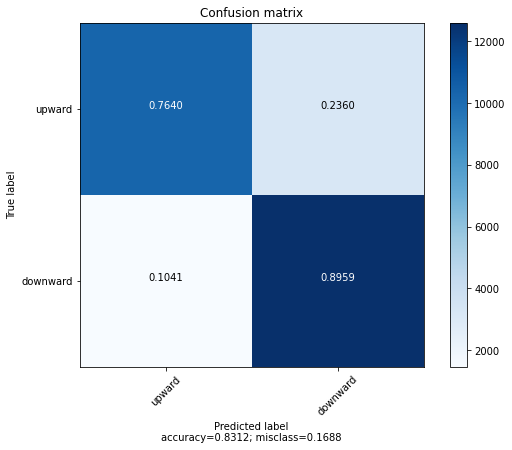

In [76]:
cm = confusion_matrix(y_true, y_pred_att_woembedding)
plot_confusion_matrix(cm,
                      ['upward','downward'],
                      title='Confusion matrix',
                      cmap=None,
                      normalize=True)

In [80]:
df_export_att = pd.DataFrame(y_pred_att_wembedding)
df_export_att.columns = ['with embedding']
df_export_att['without embedding'] = y_pred_att_woembedding
df_export_att.to_csv('/content/drive/MyDrive/ADL_Final/attention_prediction.csv')

## Transformers

In [81]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out    

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear   

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config

In [82]:
def create_transformers(X, embedding, classification):
  
  d_k = 256
  d_v = 256
  n_heads = 12
  ff_dim = 256

  input_seq = Input(shape = (X.shape[1], X.shape[2]))

  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  if embedding:
    time_embedding = Time2Vector(X.shape[1])
    x = time_embedding(input_seq)
    x = Concatenate(axis=-1)([input_seq, x])
    x = attn_layer1((x,x,x))
  else:
    x = attn_layer1((input_seq, input_seq, input_seq))
  
  x = attn_layer2((x,x,x))
  x = attn_layer3((x,x,x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)

  if classification:
    out = Dense(2, activation="softmax", name="output")(x)
    model = Model(inputs = input_seq, outputs = out)
    model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(1e-5), metrics = ['accuracy'])
  else:
    out = Dense(1)(x)
    model = Model(inputs = input_seq, outputs = out)
    model.compile(loss = 'mse', optimizer = 'Adam', metrics = ['mae', 'mape'])
  
  return model


In [84]:
X_train, y_train = convert_raw_samples_to_model_samples(df_train, Y_train, 64)
X_val, y_val = convert_raw_samples_to_model_samples(df_val, Y_val, 64)

In [85]:
#With Time Embedding
model_transformers_w_embedding = create_transformers(X_train, True, True)

In [86]:
model_transformers_w_embedding.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 64, 17)]     0                                            
__________________________________________________________________________________________________
time2_vector_4 (Time2Vector)    (None, 64, 2)        256         input_7[0][0]                    
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 64, 19)       0           input_7[0][0]                    
                                                                 time2_vector_4[0][0]             
__________________________________________________________________________________________________
transformer_encoder (Transforme (None, 64, 19)       252786      concatenate_4[0][0]        

In [87]:
history = model_transformers_w_embedding.fit(X_train, y_train,epochs=5,  validation_data=(X_val, y_val))

Epoch 1/5
2029/2029 [==============================] - 748s 359ms/step - loss: 0.6912 - accuracy: 0.5648 - val_loss: 0.6802 - val_accuracy: 0.5966
Epoch 2/5
2029/2029 [==============================] - 707s 349ms/step - loss: 0.6701 - accuracy: 0.6426 - val_loss: 0.6539 - val_accuracy: 0.6240
Epoch 3/5
2029/2029 [==============================] - 715s 353ms/step - loss: 0.6366 - accuracy: 0.6815 - val_loss: 0.6341 - val_accuracy: 0.6234
Epoch 4/5
2029/2029 [==============================] - 706s 348ms/step - loss: 0.5926 - accuracy: 0.7314 - val_loss: 0.5983 - val_accuracy: 0.6633
Epoch 5/5
2029/2029 [==============================] - 707s 348ms/step - loss: 0.5438 - accuracy: 0.7655 - val_loss: 0.5294 - val_accuracy: 0.7495


In [88]:
y_pred_transformers_w_embedding = model_transformers_w_embedding.predict(X_val)
y_pred_transformers_w_embedding = [y_pred_transformers_w_embedding[i].argmax() for i in range(len(y_pred_transformers_w_embedding))]
print(set(y_pred))

num =[0,0]
for i in range(len(y_pred_transformers_w_embedding)):
  num[y_pred_transformers_w_embedding[i]] += 1 

print(num)

y_true =  [y_val[i].argmax() for i in range(len(y_val))]
num =[0,0]
for i in range(len(y_true)):
  num[y_true[i]] += 1 
print(num)

{0, 1}
[8679, 19104]
[13615, 14168]


In [89]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_transformers_w_embedding))

              precision    recall  f1-score   support

           0       0.88      0.56      0.69     13615
           1       0.69      0.93      0.79     14168

    accuracy                           0.75     27783
   macro avg       0.79      0.75      0.74     27783
weighted avg       0.78      0.75      0.74     27783



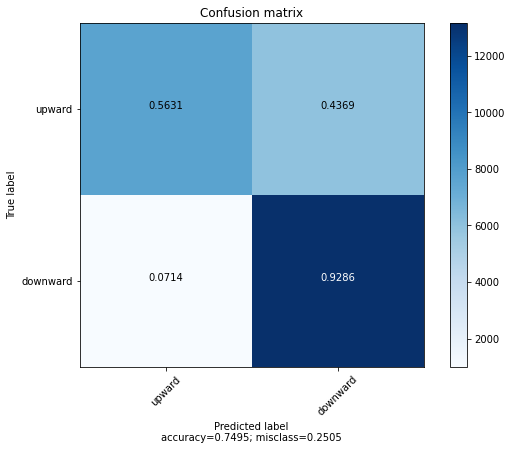

In [90]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred_transformers_w_embedding)
plot_confusion_matrix(cm,
                      ['upward','downward'],
                      title='Confusion matrix',
                      cmap=None,
                      normalize=True)

In [91]:
#Without Time Embedding
model_transformers_wo_embedding = create_transformers(X_train, False, True)
model_transformers_wo_embedding.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 64, 17)]     0                                            
__________________________________________________________________________________________________
transformer_encoder_3 (Transfor (None, 64, 17)       227174      input_8[0][0]                    
                                                                 input_8[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
transformer_encoder_4 (Transfor (None, 64, 17)       227174      transformer_encoder_3[0][0]      
                                                                 transformer_encoder_3[0][0]

In [92]:
history = model_transformers_wo_embedding.fit(X_train, y_train,epochs=5,  validation_data=(X_val, y_val))

Epoch 1/5
2029/2029 [==============================] - 747s 359ms/step - loss: 0.6909 - accuracy: 0.5929 - val_loss: 0.6774 - val_accuracy: 0.6216
Epoch 2/5
2029/2029 [==============================] - 726s 358ms/step - loss: 0.6669 - accuracy: 0.6625 - val_loss: 0.6381 - val_accuracy: 0.6907
Epoch 3/5
2029/2029 [==============================] - 726s 358ms/step - loss: 0.6279 - accuracy: 0.7055 - val_loss: 0.6002 - val_accuracy: 0.7102
Epoch 4/5
2029/2029 [==============================] - 717s 354ms/step - loss: 0.5786 - accuracy: 0.7566 - val_loss: 0.5390 - val_accuracy: 0.7839
Epoch 5/5
2029/2029 [==============================] - 707s 349ms/step - loss: 0.5238 - accuracy: 0.7828 - val_loss: 0.4962 - val_accuracy: 0.7815


In [93]:
y_pred_transformers_wo_embedding = model_transformers_wo_embedding.predict(X_val)
y_pred_transformers_wo_embedding = [y_pred_transformers_wo_embedding[i].argmax() for i in range(len(y_pred_transformers_wo_embedding))]
print(set(y_pred_transformers_wo_embedding))

num =[0,0]
for i in range(len(y_pred_transformers_wo_embedding)):
  num[y_pred_transformers_wo_embedding[i]] += 1 

print(num)

y_true =  [y_val[i].argmax() for i in range(len(y_val))]
num =[0,0]
for i in range(len(y_true)):
  num[y_true[i]] += 1 
print(num)
print(classification_report(y_true, y_pred_transformers_wo_embedding))

{0, 1}
[10419, 17364]
[13615, 14168]
              precision    recall  f1-score   support

           0       0.86      0.66      0.75     13615
           1       0.73      0.90      0.81     14168

    accuracy                           0.78     27783
   macro avg       0.80      0.78      0.78     27783
weighted avg       0.80      0.78      0.78     27783



In [95]:
df_export_transformers = pd.DataFrame(y_pred_transformers_w_embedding)
df_export_transformers.columns = ['with time embedding']
df_export_transformers['without time embedding'] = y_pred_transformers_wo_embedding
df_export_transformers.to_csv("/content/drive/MyDrive/ADL_Final/transformers_prediction.csv")

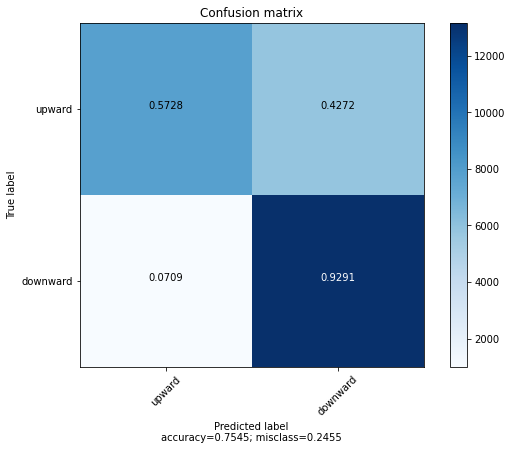

In [55]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm,
                      ['upward','downward'],
                      title='Confusion matrix',
                      cmap=None,
                      normalize=True)